In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from matplotlib import pyplot as plt

/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/jaidevd/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
base = ResNet50(include_top=False)

base.trainable = False
inputs = L.Input(shape=(224, 224, 3))
x = base(inputs, training=False)
x = L.GlobalAveragePooling2D()(x)
outputs = L.Dense(5)(x)

94773248/94765736 [==============================] - 20s 0us/step


In [3]:
model = Model(inputs, outputs)
model.compile(Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])
model.save_weights('checkpoints/resnet50_default.h5')

In [4]:
df = pd.read_csv('data/train.csv')
df = df[~df['path'].str.endswith('.gif')]

In [5]:
histories = []

for i, (trix, tsix) in enumerate(StratifiedKFold(n_splits=4).split(df, df['class'])):
    train_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        width_shift_range=[-60, 60], height_shift_range=[-60, 60],
        horizontal_flip=True, vertical_flip=True,
        zoom_range=[0.5, 1.5]
    ).flow_from_dataframe(df.iloc[trix], x_col='path', target_size=(224, 224), validate_filenames=False)
    test_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input
    ).flow_from_dataframe(df.iloc[tsix], x_col='path', target_size=(224, 224), validate_filenames=False)
    model.load_weights('checkpoints/resnet50_default.h5')
    h = model.fit(
        train_gen, validation_data=test_gen, epochs=100,
        callbacks=[EarlyStopping(min_delta=0.01, patience=30, restore_best_weights=True)],
        verbose=2
    )
    model.save(f'checkpoints/resnet50_fold_{i}.h5')
    pd.DataFrame.from_dict(h.history).to_csv(f'checkpoints/resnet50_fold_{i}_history.csv', index=False)

Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.
Epoch 1/100
10/10 - 12s - loss: 1.7633 - categorical_accuracy: 0.3460 - val_loss: 1.0125 - val_categorical_accuracy: 0.5876


/home/jaidevd/conda/lib/python3.7/site-packages/PIL/Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2/100
10/10 - 10s - loss: 0.9492 - categorical_accuracy: 0.6055 - val_loss: 0.5939 - val_categorical_accuracy: 0.7938
Epoch 3/100
10/10 - 10s - loss: 0.6711 - categorical_accuracy: 0.7266 - val_loss: 0.4356 - val_categorical_accuracy: 0.8557
Epoch 4/100
10/10 - 9s - loss: 0.5534 - categorical_accuracy: 0.8097 - val_loss: 0.3686 - val_categorical_accuracy: 0.8866
Epoch 5/100
10/10 - 9s - loss: 0.4573 - categorical_accuracy: 0.8374 - val_loss: 0.3071 - val_categorical_accuracy: 0.9175
Epoch 6/100
10/10 - 9s - loss: 0.4440 - categorical_accuracy: 0.8408 - val_loss: 0.2907 - val_categorical_accuracy: 0.9072
Epoch 7/100
10/10 - 9s - loss: 0.4231 - categorical_accuracy: 0.8478 - val_loss: 0.2612 - val_categorical_accuracy: 0.9072
Epoch 8/100
10/10 - 9s - loss: 0.3932 - categorical_accuracy: 0.8581 - val_loss: 0.2407 - val_categorical_accuracy: 0.9072
Epoch 9/100
10/10 - 9s - loss: 0.3928 - categorical_accuracy: 0.8651 - val_loss: 0.2963 - val_categorical_accuracy: 0.9072
Epoch 10/100
1

/home/jaidevd/conda/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Found 289 non-validated image filenames belonging to 5 classes.
Found 97 non-validated image filenames belonging to 5 classes.
Epoch 1/100
10/10 - 10s - loss: 1.5572 - categorical_accuracy: 0.3737 - val_loss: 0.8221 - val_categorical_accuracy: 0.6186
Epoch 2/100
10/10 - 9s - loss: 0.7017 - categorical_accuracy: 0.7336 - val_loss: 0.4736 - val_categorical_accuracy: 0.7835
Epoch 3/100
10/10 - 9s - loss: 0.4843 - categorical_accuracy: 0.7889 - val_loss: 0.3978 - val_categorical_accuracy: 0.8763
Epoch 4/100
10/10 - 9s - loss: 0.3858 - categorical_accuracy: 0.8651 - val_loss: 0.4135 - val_categorical_accuracy: 0.8763
Epoch 5/100
10/10 - 9s - loss: 0.3548 - categorical_accuracy: 0.8685 - val_loss: 0.4145 - val_categorical_accuracy: 0.8660
Epoch 6/100
10/10 - 9s - loss: 0.3391 - categorical_accuracy: 0.8789 - val_loss: 0.3600 - val_categorical_accuracy: 0.8866
Epoch 7/100
10/10 - 9s - loss: 0.2927 - categorical_accuracy: 0.8927 - val_loss: 0.3625 - val_categorical_accuracy: 0.8969
Epoch 8/100

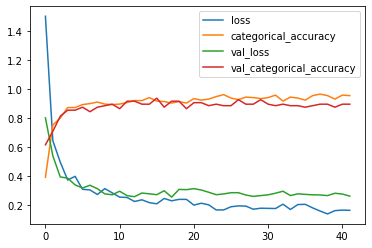

In [6]:
for k, v in h.history.items():
    plt.plot(v, label=k)
plt.legend()